In [78]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from tqdm.keras import TqdmCallback
from tqdm import trange, tqdm

import itertools
import sys;sys.path.append('..')
import utils

import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding, MemoryAddPositionalEmbedding
from custom_attention import GlobalSelfAttention, CausalSelfAttention, CrossAttention


In [86]:
# Training
inputs = []
outputs = []

# Open the file in read mode
with open('tasks_train_addprim_jump.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip()  # Removing leading and trailing whitespaces
        input, output = line.split('IN:')[1].split('OUT:')
        inputs.append(input.strip())  # Appending the input data after removing the 'IN: ' prefix
        outputs.append(output.strip())  # Appending the output data after removing the 'OUT: ' prefix

# Printing the inputs and outputs lists
print("Inputs:", inputs[0])
print("Outputs:", outputs[0])
total_num_of_training_data = 1000 #len(inputs)
num_of_training_memory = 100
train_memory_indices = random.sample(range(total_num_of_training_data), num_of_training_memory)
num_of_training_data = total_num_of_training_data - num_of_training_memory


# index out memory from training input and output
inputs = np.array(inputs)[:total_num_of_training_data]
outputs = np.array(outputs)[:total_num_of_training_data]
print(inputs.shape)
seqs_x_train = np.array(inputs)
seqs_y_train = np.array(outputs)


mask_train = np.ones(inputs.shape, dtype=bool)
mask_train[train_memory_indices] = False


Inputs: jump
Outputs: I_JUMP
(1000,)


In [87]:
# testing
inputs = []
outputs = []

# Open the file in read mode
with open('tasks_test_addprim_jump.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip()  # Removing leading and trailing whitespaces
        input, output = line.split('IN:')[1].split('OUT:')
        inputs.append(input.strip())  # Appending the input data after removing the 'IN: ' prefix
        outputs.append(output.strip())  # Appending the output data after removing the 'OUT: ' prefix

# Printing the inputs and outputs lists
print("Inputs:", inputs[0])
print("Outputs:", outputs[0])
total_num_of_testing_data = 6000 
num_of_testing_memory = 100
test_memory_indices = random.sample(range(total_num_of_testing_data), num_of_testing_memory)
num_of_testing_data = total_num_of_testing_data - num_of_testing_memory

# index out memory from testing input and output
inputs = np.array(inputs)[:total_num_of_testing_data]
outputs = np.array(outputs)[:total_num_of_testing_data]
print(inputs.shape)

# Create new array with elements removed

seqs_x_test = np.array(inputs)
seqs_y_test = np.array(outputs)


mask_test = np.ones(inputs.shape, dtype=bool)
mask_test[test_memory_indices] = False


Inputs: jump opposite right twice and turn opposite right thrice
Outputs: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT
(6000,)


(array([ 879., 1599., 1194.,  831.,  456.,  546.,  344.,   44.,   60.,
          47.]),
 array([ 1.2 ,  5.87, 10.54, 15.21, 19.88, 24.55, 29.22, 33.89, 38.56,
        43.23, 47.9 ]),
 <BarContainer object of 10 artists>)

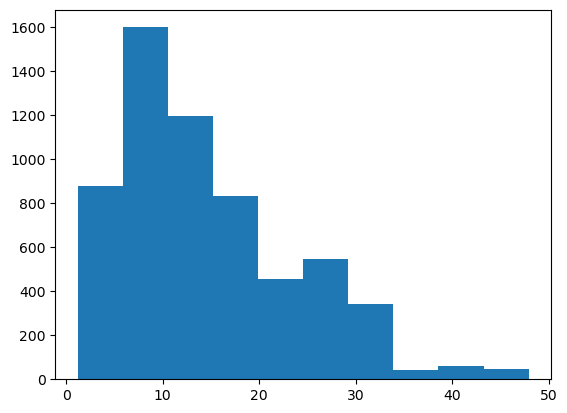

In [88]:
plt.hist([len(output)/10 for output in outputs])

In [89]:
import nltk
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

#nltk.download('punkt')

def tokenize_texts(texts):
    """
    Tokenizes a list of texts using NLTK's word tokenizer.
    
    Args:
    - texts (list of str): The list containing texts to be tokenized.
    
    Returns:
    - tokenized_texts (list of list of str): The tokenized texts.
    - vocab (dict): A mapping from word to unique integer.
    """
    
    # Tokenizing each text in the list
    tokenized_texts = [word_tokenize(text) for text in texts]

    # Building a vocabulary
    vocab = {}
    idx = 1
    for tokens in tokenized_texts:
        for word in tokens:
            if word not in vocab:
                vocab[word] = idx
                idx += 1
                
    # Converting each text to a sequence of integers
    sequences = [[vocab[word] for word in tokens] for tokens in tokenized_texts]
    input_seqs = pad_sequences(sequences, padding='post')
    print(np.array(input_seqs).shape)
    # Getting the vocabulary size
    vocab_size = len(vocab) + 1  # Adding 1 because of the reserved 0 index
    return vocab, np.array(input_seqs), vocab_size


vocab, sequences, vocab_size = tokenize_texts(seqs_y_test)

print("Vocab:", vocab)
print("Sequences:", sequences)
print("Vocabulary:", vocab_size)


(6000, 48)
Vocab: {'I_TURN_RIGHT': 1, 'I_JUMP': 2, 'I_TURN_LEFT': 3, 'I_RUN': 4, 'I_WALK': 5, 'I_LOOK': 6}
Sequences: [[1 1 2 ... 0 0 0]
 [3 2 3 ... 0 0 0]
 [3 3 5 ... 0 0 0]
 ...
 [1 6 1 ... 0 0 0]
 [1 1 6 ... 0 0 0]
 [5 3 2 ... 0 0 0]]
Vocabulary: 7


In [90]:
_, seqs_x_train_token, vocab_size_x_train = tokenize_texts(seqs_x_train)
_, seqs_y_train_token, vocab_size_y_train = tokenize_texts(seqs_y_train)

mem_x_train_token = seqs_x_train_token[~mask_train]
mem_y_train_token = seqs_y_train_token[~mask_train]

seqs_x_train_token = seqs_x_train_token[mask_train]
seqs_y_train_token = seqs_y_train_token[mask_train]


test_x_vocab, seqs_x_test_token, vocab_size_x_test = tokenize_texts(seqs_x_test)
test_y_vocab, seqs_y_test_token, vocab_size_y_test = tokenize_texts(seqs_y_test)
mem_x_test_token = seqs_x_test_token[~mask_test]
mem_y_test_token = seqs_y_test_token[~mask_test]
seqs_x_test_token = seqs_x_test_token[mask_test]
seqs_y_test_token = seqs_y_test_token[mask_test]


mem_x_test_token = np.tile(mem_x_test_token, (num_of_testing_data, 1, 1))
mem_y_test_token = np.tile(mem_y_test_token, (num_of_testing_data, 1, 1))

mem_x_train_token = np.tile(mem_x_train_token, (num_of_training_data, 1, 1))
mem_y_train_token = np.tile(mem_y_train_token, (num_of_training_data, 1, 1))



# Print the shape of the new array to confirm
print(seqs_x_train_token.shape) 
print(seqs_y_train_token.shape) 
print(mem_x_train_token.shape) 
print(mem_y_train_token.shape)  


(1000, 9)
(1000, 48)
(6000, 9)
(6000, 48)
(900, 9)
(900, 48)
(900, 100, 9)
(900, 100, 48)


In [91]:
train_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_train_token, mem_x_train_token, mem_y_train_token), seqs_y_train_token)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(((seqs_x_test_token, mem_x_test_token, mem_y_test_token), seqs_y_test_token)).batch(64)

In [92]:
import tensorflow as tf
from tensorflow.keras import layers
from transformer_modules import AddPositionalEmbedding

# Model Configuration
input_vocab_size = vocab_size_x_train
output_vocab_size = vocab_size_y_train
embedding_dim = 64
n_heads = 4
ff_dim = 256  # Feed-forward layer size
max_seq_len = max(len(seq) for seq in seqs_x_train_token)  # Assuming your sequences might have variable lengths

# Multi-head self attention mechanism
def transformer_encoder(inputs):

    x = layers.Embedding(input_vocab_size, embedding_dim)(inputs)
    x = AddPositionalEmbedding(max_seq_len, name="encoder_positional_embedding")(x)
    
    attn_output = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(embedding_dim)(ff_output)
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    return x


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)



# Transformer decoder block
def transformer_decoder(inputs, encoder_outputs):

    x = layers.Embedding(output_vocab_size, embedding_dim)(inputs)
    x = AddPositionalEmbedding(max_seq_len, name="decoder_positional_embedding")(x)  # This max_seq_len should be based on decoder's sequence length
    
    # Mask for the subsequent tokens in the decoder to prevent predicting future tokens
    look_ahead_mask = create_look_ahead_mask(tf.shape(inputs)[1])
    
    # Self attention for decoder
    attn1 = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim)
    attn_out1 = attn1(x, x, attention_mask=look_ahead_mask)
    x = layers.Add()([x, attn_out1])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Attention with encoder's output
    attn2 = layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim)
    attn_out2 = attn2(x, encoder_outputs)
    x = layers.Add()([x, attn_out2])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    ff_output = layers.Dense(ff_dim, activation="relu")(x)
    ff_output = layers.Dense(embedding_dim)(ff_output)
    x = layers.Add()([x, ff_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    return x


In [93]:
# Model Architecture
encoder_inputs = layers.Input(shape=seqs_x_train_token.shape[1],)
encoder_outputs = transformer_encoder(encoder_inputs)

# Using shifted target sequences as input for the decoder
decoder_inputs = layers.Input(shape=seqs_y_train_token.shape[1]-1,)
decoder_outputs = transformer_decoder(decoder_inputs, encoder_outputs)

final_outputs = layers.TimeDistributed(layers.Dense(output_vocab_size, activation="softmax"))(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs], outputs=final_outputs)
optimizer = tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

# Prepare decoder inputs ( shift the y sequences by one, remove the last token)
decoder_input_data = seqs_y_train_token[:, :-1]

# Prepare decoder outputs (we remove the start token)
decoder_output_data = seqs_y_train_token[:, 1:]

batch_size = 64
model.fit([seqs_x_train_token, decoder_input_data], decoder_output_data, batch_size=batch_size, epochs=10, validation_split=0.05)


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_30 (InputLayer)          [(None, 9)]          0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 47)]         0           []                               
                                                                                                  
 embedding_29 (Embedding)       (None, 9, 64)        896         ['input_30[0][0]']               
                                                                                                  
 tf.compat.v1.shape_11 (TFOpLam  (2,)                0           ['input_31[0][0]']               
 bda)                                                                                      

In [59]:
print(seqs_x_train_token.shape)
print(seqs_y_train_token.shape)

(3000, 9)
(3000, 48)


In [71]:
# Prepare the test decoder inputs (shift the y sequences by one, remove the last token)
decoder_test_input_data = seqs_y_test_token[:, :-1]

# Prepare the test decoder outputs (remove the start token)
decoder_test_output_data = seqs_y_test_token[:, 1:]

# Evaluate the model on the test data
loss, accuracy = model.evaluate([seqs_x_test_token, decoder_test_input_data], decoder_test_output_data, batch_size=batch_size)

print(f"Test Accuracy: {accuracy * 100:.2f}%")


93/93 [==============================] - 2s 27ms/step - loss: 0.7908 - accuracy: 0.9012
Test Accuracy: 90.12%


In [75]:
print(seqs_x_test_token.shape)
print(seqs_y_test_token.shape)
print("Number of test data: ", seqs_x_test_token.shape[0])

(5900, 9)
(5900, 48)
Number of test data:  5900


In [74]:
# 1. Predict the sequences on test data
predicted_output = model.predict([seqs_x_test_token, decoder_test_input_data])

# 2. Convert the predicted sequences from probability distributions to token IDs
predicted_token_ids = np.argmax(predicted_output, axis=-1)

# Store failed cases
failed_cases = []

# Build the id_to_word mapping from vocab

def output_ids_to_scan_sequence(ids_sequence, test_y_vocab):
    id_to_word = {id: word for word, id in test_y_vocab.items()}
    words = [id_to_word[token_id] for token_id in ids_sequence if token_id != 0]  # 0 denotes padding
    return ' '.join(words)

def input_ids_to_scan_sequence(ids_sequence, test_x_vocab):
    id_to_word = {id: word for word, id in test_x_vocab.items()}
    words = [id_to_word[token_id] for token_id in ids_sequence if token_id != 0]  # 0 denotes padding
    return ' '.join(words)

for i, (input_seq, predicted_sequence, true_sequence) in enumerate(zip(seqs_x_test_token, predicted_token_ids, seqs_y_test_token)):
    if not np.array_equal(predicted_sequence, true_sequence[1:]):
        failed_cases.append((i, input_seq, predicted_sequence, true_sequence))

        # Convert tokenized sequences back to SCAN commands
        print("Input seq:", input_ids_to_scan_sequence(input_seq, test_x_vocab))
        print("Predicted seq:", output_ids_to_scan_sequence(predicted_sequence, test_y_vocab))
        print("True seq:", output_ids_to_scan_sequence(true_sequence, test_y_vocab))
        print("-----")
print("number of failed cases: ", len(failed_cases))



185/185 [==============================] - 3s 15ms/step
Input seq: jump opposite right twice and turn opposite right thrice
Predicted seq: I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP
True seq: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT
-----
Input seq: jump right thrice and run left thrice
Predicted seq: I_JUMP I_JUMP I_JUMP I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN
True seq: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN
-----
Input seq: jump around right twice after look left thrice
Predicted seq: I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP I_JUMP
True seq: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT 

## Our Proposed Models

In [77]:

class KernelMemoryTransformer(tf.keras.Model):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, key_dim, n_heads, ff_sizes, symmetric_attention=False, crossAttn_value_shifted=False, gamma=0,**kwargs):
        super().__init__(**kwargs)

        self.gamma = gamma
        self.symmetric_attention = symmetric_attention
        self.crossAttn_value_shifted = crossAttn_value_shifted
        self.input_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='embedder')
        self.output_embedder = layers.Embedding(output_vocab_size, embedding_dim, name='embedder')

        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')
        
        # different self-attention layers for input and memories for encoding sequences
        self.input_self_attention = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.input_self_attention
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # create cross attention layer                             
        self.cross_attention_layer = CrossAttention(num_heads=n_heads, key_dim=key_dim, value_dim = key_dim, symmetric_attention=symmetric_attention, name='cross_attn')

        self.feedforward = tf.keras.Sequential([layers.Dense(z, activation='relu') for z in ff_sizes], name='feedforward')
        self.output_dense = layers.Dense(output_vocab_size, activation='softmax', name='output')

    def memory_self_attention(self, mem_seqs):
        '''apply self-attention to each memory sequence'''
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def get_cross_probs(self, embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs):
        '''compute cross attention probabilities prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory'''
       
        def get_memory_cross_probs(Et, Et_y):
            cross_attention_output = self.cross_attention_layer(
                x=embedded_input_seqs,
                context=Et,
                y=Et_y)
            return cross_attention_output # shape: (batch_size, seq_len, mem_len)

        # compute cross-attention for each memory
        embedded_mem_x_seqs = tf.transpose(embedded_mem_x_seqs, perm=[1, 0, 2, 3])
        if self.crossAttn_value_shifted:
            embedded_mem_y_seqs = tf.transpose(embedded_mem_y_seqs, perm=[1, 0, 2, 3]) 
        else:
             embedded_mem_y_seqs =  embedded_mem_x_seqs
             
        cross_probs = tf.map_fn(lambda xy: get_memory_cross_probs(xy[0], xy[1]), 
                            (embedded_mem_x_seqs, embedded_mem_y_seqs),
                            dtype=tf.float32)
        cross_probs = tf.transpose(cross_probs, perm=[1, 0, 2, 3]) # shape: (batch_size, n_mem, mem_length, embedding_dim)

        # compute cross-probs from cross-attention via feedforward network
        cross_probs = self.feedforward(cross_probs)
        cross_probs = self.output_dense(cross_probs) # shape: (batch_size, n_mems, mem_length, vocab_size)

        return cross_probs

    def get_observed_cross_probs(self, cross_probs, seq_input):
        '''given the cross_probs tensor, extract the components corresponding to the observed sequence'''

        cross_probs_observed = tf.transpose(cross_probs, perm=(1,0,2,3))
        cross_probs_observed = tf.map_fn(lambda x: tf.gather(x, indices=seq_input, axis=-1, batch_dims=2), cross_probs_observed)
        cross_probs_observed = tf.transpose(cross_probs_observed, perm=(1,0,2))
        return cross_probs_observed


    def compute_mem_attention_scores(self, cross_probs_observed, input_seq_length):
        log_cross_probs_observed = tf.math.log(cross_probs_observed)

        # Initialize the first element of w_it with zeros
        # The first element is zeros, and the rest is calculated by tf.scan
        def scan_func(prev_w, curr_log_prob):
            next_w = self.gamma * prev_w + curr_log_prob
            return next_w

        #print("log_cross_probs_observed", log_cross_probs_observed)
        w_it = tf.scan(scan_func, tf.transpose(log_cross_probs_observed, perm=[2,1,0]))
        w_it = tf.transpose(w_it, perm=[2,1,0])
        #print("w_it", w_it)
        
        alpha_it = tf.nn.softmax(w_it, axis=1) # shape [batch_size, num_mems, in_seq_length]
        return alpha_it  
    
    def call(self, inputs):
        
        # handle crossAttn value
        embedded_mem_y_seqs = None
        if self.crossAttn_value_shifted:
            seq_input, memory_input, memory_output = inputs
            embedded_mem_y_seqs = self.output_embedder(memory_output)
            embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        else:
            seq_input, memory_input = inputs
        

        # embed input sequences and memory sequences
        embedded_input_seqs = self.input_embedder(seq_input)
        embedded_mem_x_seqs = self.input_embedder(memory_input)

        # add positional embeddings
        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        # add mem_y_seq embed
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)
        embedded_mem_y_seqs = self.memory_self_attention(embedded_mem_y_seqs)


        # encode via self-attention
        embedded_input_seqs = self.input_self_attention(embedded_input_seqs) # shape: (batch_size, input_length, embedding_dim)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs) # shape: (batch_size, num_memories, memory_length, embedding_dim)

        # normal transformer (only encoder)
        # cross_probs = self.input_self_attention(embedded_input_seqs, embedded_input_seqs, embedded_input_seqs)
        cross_probs = self.feedforward(embedded_input_seqs)
        cross_probs = self.output_dense(cross_probs)
        encoder_output = tf.nn.softmax(cross_probs, axis=-1)
        
    
        # compute prob(x_{i+1} = . | x_{1:i}, x^{(t)}) for each memory
        cross_probs_mem_on = self.get_cross_probs(embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs)

        # compute prob(x_{i+1} | x_{1:i}, x^{(t)}) for each memory
        cross_probs_observed = self.get_observed_cross_probs(cross_probs_mem_on, seq_input)

        # compute alpha_it = softmax(w_it) where w_it = sum_{j=1}^{i-1} log prob(x_{j+1} | x_{1:j}, x^{(t)})
        input_seq_len = seq_input.shape[-1]
        alpha_it = self.compute_mem_attention_scores(cross_probs_observed, input_seq_len)
        self.alpha_it = alpha_it

        # compute prob(x_{i+1} | x_{1:i}, {x^{(t)}}_t) = \sum_t alpha_it * prob(x_{i+1} = . | x_{1:i}, x^{(t)})
        output = tf.reduce_sum(tf.multiply(tf.expand_dims(alpha_it, axis=-1), cross_probs_mem_on), axis=1)

        return output


In [ ]:
from transformer_modules import AddPositionalEmbedding, create_positional_encoding, MemoryAddPositionalEmbedding
from transformer_modules import GlobalSelfAttention, CausalSelfAttention
from hierarchical_attention import MultiHeadHierarchicalAttention


class HierarchicalAttnMemoryModel(tf.keras.Model):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, key_dim, n_heads, symmetric_attention=False, **kwargs):
        super().__init__(**kwargs)
        self.input_embedder = layers.Embedding(input_vocab_size, embedding_dim, name='embedder')
        self.output_embedder = layers.Embedding(output_vocab_size, embedding_dim, name='embedder')

        self.pos_embedder_adder  = AddPositionalEmbedding(name='pos_embedder_adder')
        self.memory_pos_embedder_adder = MemoryAddPositionalEmbedding(name='mem_pos_embedder_adder')

        # different attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        # self.memory_self_attention_layer = layers.MultiHeadAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')
        self.self_attention_layer = CausalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='self_attn')
        if symmetric_attention:
            self.memory_self_attention_layer = self.self_attention_layer
        else:
            self.memory_self_attention_layer = GlobalSelfAttention(num_heads=n_heads, key_dim=key_dim, name='mem_self_attn')

        # same attention layers for input and memories
        # self.self_attention_layer = layers.MultiHeadAttention(num_heads=1, key_dim=key_dim, value_dim=embedding_dim, name='self_attn')
        # self.memory_self_attention_layer = self.self_attention_layer

        self.hierarchical_mem_attention = MultiHeadHierarchicalAttention(
            key_dim, value_dim=embedding_dim, symmetric_kernel=True, n_heads=n_heads,
            attn_scale_factor_per_seq=1, attn_scale_factor_over_seqs=1,
            dense_kwargs=dict(use_bias=False), name='mem_attn')

        self.output_dense = layers.Dense(output_vocab_size, name='output')

    def self_attention(self, seq):
        # return self.self_attention_layer(seq, seq, use_causal_mask=True)
        return self.self_attention_layer(seq)

    def memory_self_attention(self, mem_seqs):
        # lambda_fn = lambda x: self.memory_self_attention_layer(x, x, use_causal_mask=True)
        lambda_fn = lambda x: self.memory_self_attention_layer(x)
        return tf.map_fn(lambda_fn, mem_seqs)

    def call(self, inputs):
        seq_input, memory_x_input, memory_y_input = inputs

        embedded_input_seqs = self.input_embedder(seq_input)
        embedded_mem_x_seqs = self.input_embedder(memory_x_input)
        embedded_mem_y_seqs = self.output_embedder(memory_y_input)

        embedded_input_seqs = self.pos_embedder_adder(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_pos_embedder_adder(embedded_mem_x_seqs)
        embedded_mem_y_seqs = self.memory_pos_embedder_adder(embedded_mem_y_seqs)

        embedded_input_seqs = self.self_attention(embedded_input_seqs)
        embedded_mem_x_seqs = self.memory_self_attention(embedded_mem_x_seqs)

        retrieved_mems = self.hierarchical_mem_attention([embedded_input_seqs, embedded_mem_x_seqs, embedded_mem_y_seqs])

        logits = self.output_dense(retrieved_mems)

        return logits

In [ ]:
input_vocab_size = vocab_size_x_train
output_vocab_size = vocab_size_y_train
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    input_vocab_size,output_vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [output_vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, gamma=0.7, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train_token[:64], mem_x_train_token[:64], mem_y_train_token[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

In [ ]:

input_vocab_size = vocab_size_x_train
output_vocab_size = vocab_size_y_train
embedding_dim = 64
kernel_model_cross_y = KernelMemoryTransformer(
    input_vocab_size,output_vocab_size, embedding_dim=embedding_dim,
    key_dim=embedding_dim//4, n_heads=4, ff_sizes = [output_vocab_size,], symmetric_attention = True, crossAttn_value_shifted = True, gamma=0.7, name='kernel_model_cross_y')


kernel_model_cross_y([seqs_x_train_token[:64], mem_x_train_token[:64], mem_y_train_token[:64]]); # build model
create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
kernel_model_cross_y.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
kernel_model_cross_y.summary()

In [ ]:
input_vocab_size = vocab_size_x_train
output_vocab_size = vocab_size_y_train
embedding_dim = 64

hierattn_model = HierarchicalAttnMemoryModel(
    input_vocab_size,output_vocab_size, embedding_dim=embedding_dim, symmetric_attention=True,
    key_dim=embedding_dim//3, n_heads=3, name='memory_model')

hierattn_model(next(iter(train_ds))[0]); # build model

create_opt = lambda: tf.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
hierattn_model.compile(optimizer=create_opt(), loss=loss, metrics=['accuracy'])
hierattn_model.summary()